# HW7

## Minling Zhou
## netid: mz246

## 2) Code to use pre-trained BERT:

In [1]:
! pip install datasets
import collections
import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.4 MB/s eta 0:00:00


In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [3]:
data = datasets.load_dataset("openai/webgpt_comparisons", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/19578 [00:00<?, ? examples/s]

In [4]:
data

Dataset({
    features: ['question', 'quotes_0', 'answer_0', 'tokens_0', 'score_0', 'quotes_1', 'answer_1', 'tokens_1', 'score_1'],
    num_rows: 19578
})

In [5]:
train_test_split = data.train_test_split(test_size=0.15)
train_data = train_test_split["train"]
test_data = train_test_split["test"]

# test_data = test_data.train_test_split(test_size=0.02)
# test_data = test_data["test"]

train_valid_split = train_data.train_test_split(test_size=0.2)
train_data = train_valid_split["train"]
valid_data = train_valid_split["test"]
train_data, valid_data, test_data

(Dataset({
     features: ['question', 'quotes_0', 'answer_0', 'tokens_0', 'score_0', 'quotes_1', 'answer_1', 'tokens_1', 'score_1'],
     num_rows: 13312
 }),
 Dataset({
     features: ['question', 'quotes_0', 'answer_0', 'tokens_0', 'score_0', 'quotes_1', 'answer_1', 'tokens_1', 'score_1'],
     num_rows: 3329
 }),
 Dataset({
     features: ['question', 'quotes_0', 'answer_0', 'tokens_0', 'score_0', 'quotes_1', 'answer_1', 'tokens_1', 'score_1'],
     num_rows: 2937
 }))

In [6]:
transformer_name = "bert-base-uncased"

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [7]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids_0 = tokenizer.encode_plus(
        example["question"]["full_text"],
        example["answer_0"],
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=512,
        truncation=True,
    )["input_ids"]

    ids_1 = tokenizer.encode_plus(
        example["question"]["full_text"],
        example["answer_1"],
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=512,
        truncation=True,
    )["input_ids"]

    if example["score_0"] > 0:
        label = 1
    elif example["score_0"] < 0:
        label = 0
    else:
        label = -1

    return {"ids_0": ids_0, "ids_1": ids_1, "label": label}

In [8]:
train_data = train_data.map(
    tokenize_and_numericalize_example,
    fn_kwargs={"tokenizer": tokenizer},
)
valid_data = valid_data.map(
    tokenize_and_numericalize_example,
    fn_kwargs={"tokenizer": tokenizer},
)
test_data = test_data.map(
    tokenize_and_numericalize_example,
    fn_kwargs={"tokenizer": tokenizer},
)

Map:   0%|          | 0/13312 [00:00<?, ? examples/s]

Map:   0%|          | 0/3329 [00:00<?, ? examples/s]

Map:   0%|          | 0/2937 [00:00<?, ? examples/s]

In [9]:
# Define a filter function
def filter_labels(example):
    return example["label"] != -1


# Apply the filter
train_data = train_data.filter(filter_labels)
valid_data = valid_data.filter(filter_labels)
test_data = test_data.filter(filter_labels)

Filter:   0%|          | 0/13312 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3329 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2937 [00:00<?, ? examples/s]

In [10]:
train_data, valid_data, test_data

(Dataset({
     features: ['question', 'quotes_0', 'answer_0', 'tokens_0', 'score_0', 'quotes_1', 'answer_1', 'tokens_1', 'score_1', 'ids_0', 'ids_1', 'label'],
     num_rows: 9750
 }),
 Dataset({
     features: ['question', 'quotes_0', 'answer_0', 'tokens_0', 'score_0', 'quotes_1', 'answer_1', 'tokens_1', 'score_1', 'ids_0', 'ids_1', 'label'],
     num_rows: 2431
 }),
 Dataset({
     features: ['question', 'quotes_0', 'answer_0', 'tokens_0', 'score_0', 'quotes_1', 'answer_1', 'tokens_1', 'score_1', 'ids_0', 'ids_1', 'label'],
     num_rows: 2165
 }))

In [11]:
pad_index = tokenizer.pad_token_id

In [12]:
train_data = train_data.with_format(type="torch", columns=["ids_0", "ids_1", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids_0", "ids_1", "label"])
test_data = test_data.with_format(type="torch", columns=["ids_0", "ids_1", "label"])

In [13]:
tokenizer.decode(train_data[0]["ids_0"])

'[CLS] how to buff out / repair minor car scratches! [SEP] the first step in buffing out a minor scratch is to wash and dry the car completely [ 1, 3 ]. if the scratch is very minor, you can try buffing it out with a polishing compound applied with a microfiber towel [ 1, 3 ]. if this does not work, try using a different brand of polish or a paste scratch remover [ 2 ]. if the scratch is still there, try applying more pressure or using faster motions when applying the polish [ 2 ]. you can also try using a toothbrush to apply the polish to the scratch in order to make the application process more precise [ 1, 3 ]. [SEP]'

In [14]:
tokenizer.decode(train_data[0]["ids_1"])

'[CLS] how to buff out / repair minor car scratches! [SEP] there are a number of ways to remove minor scratches from a car. one method is to wet the scratch and sandpaper and then lightly sand the area until the finish looks dull and the scratch is no longer obvious. then clean the surface with a microfiber towel. [ 1 ] another method is to apply compound. you will need to spread the compound on a polishing pad and then run the polisher or drill at 1, 200 rpm until you get a light haze. follow up with polishing compound to restore the shine. [ 1 ] yet another method is buffing. this involves polishing or rubbing compounds to remove scratches. in buffing, a thin layer of paint from the vehicle surface is removed that also takes scratches and swirls along with it, ultimately leaving you with a shiny, flawless, and smooth paint surface. [ 2 ] [SEP]'

In [15]:
train_data[0]["label"]

tensor(0)

In [16]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids_0 = [i["ids_0"] for i in batch]
        batch_ids_0 = nn.utils.rnn.pad_sequence(
            batch_ids_0, padding_value=pad_index, batch_first=True
        )
        batch_ids_1 = [i["ids_1"] for i in batch]
        batch_ids_1 = nn.utils.rnn.pad_sequence(
            batch_ids_1, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids_0": batch_ids_0, "ids_1": batch_ids_1, "label": batch_label}
        return batch

    return collate_fn

In [17]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [18]:
batch_size = 8

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [19]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        attention = output.attentions[-1]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(cls_hidden)
        return prediction

In [20]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [21]:
transformer.config.hidden_size

768

In [22]:
output_dim = len(train_data["label"].unique())
freeze = True

model = Transformer(transformer, output_dim, freeze)

In [23]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,538 trainable parameters


In [24]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)

In [25]:
criterion = nn.CrossEntropyLoss()

In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

In [27]:
model = model.to(device)
criterion = criterion.to(device)

In [28]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [29]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids_0 = batch["ids_0"].to(device)  # input (sm, aim)
        ids_1 = batch["ids_1"].to(device)  # input (sm, ajm)
        label = batch["label"].to(device)
        prediction_0 = model(ids_0)  # calculate w * Oim
        prediction_1 = model(ids_1)  # calculate w * Ojm
        prob_0 = torch.exp(prediction_0) / (
            torch.exp(prediction_0) + torch.exp(prediction_1)
        )  # calculate the probability of Oim
        prob_1 = 1 - prob_0
        loss = criterion(prob_0, label)
        accuracy = get_accuracy(prob_0, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [30]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids_0 = batch["ids_0"].to(device)
            ids_1 = batch["ids_1"].to(device)
            label = batch["label"].to(device)
            prediction_0 = model(ids_0)
            prediction_1 = model(ids_1)
            prob_0 = torch.exp(prediction_0) / (
                torch.exp(prediction_0) + torch.exp(prediction_1)
            )
            prob_1 = 1 - prob_0
            loss = criterion(prob_0, label)
            accuracy = get_accuracy(prob_0, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [31]:
n_epochs = 10
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 304/304 [00:29<00:00, 10.48it/s]


epoch: 0
train_loss: 0.688, train_acc: 0.551
valid_loss: 0.685, valid_acc: 0.564


evaluating...: 100%|██████████| 304/304 [00:28<00:00, 10.52it/s]


epoch: 1
train_loss: 0.681, train_acc: 0.571
valid_loss: 0.680, valid_acc: 0.571


evaluating...: 100%|██████████| 304/304 [00:28<00:00, 10.51it/s]


epoch: 2
train_loss: 0.676, train_acc: 0.581
valid_loss: 0.677, valid_acc: 0.573


evaluating...: 100%|██████████| 304/304 [00:28<00:00, 10.50it/s]


epoch: 3
train_loss: 0.674, train_acc: 0.577
valid_loss: 0.675, valid_acc: 0.571


evaluating...: 100%|██████████| 304/304 [00:29<00:00, 10.47it/s]


epoch: 4
train_loss: 0.672, train_acc: 0.578
valid_loss: 0.674, valid_acc: 0.574


evaluating...: 100%|██████████| 304/304 [00:28<00:00, 10.53it/s]


epoch: 5
train_loss: 0.670, train_acc: 0.586
valid_loss: 0.673, valid_acc: 0.573


evaluating...: 100%|██████████| 304/304 [00:28<00:00, 10.53it/s]


epoch: 6
train_loss: 0.670, train_acc: 0.577
valid_loss: 0.672, valid_acc: 0.573


evaluating...: 100%|██████████| 304/304 [00:28<00:00, 10.56it/s]


epoch: 7
train_loss: 0.670, train_acc: 0.579
valid_loss: 0.672, valid_acc: 0.575


evaluating...: 100%|██████████| 304/304 [00:28<00:00, 10.56it/s]


epoch: 8
train_loss: 0.669, train_acc: 0.585
valid_loss: 0.672, valid_acc: 0.577


evaluating...: 100%|██████████| 304/304 [00:28<00:00, 10.54it/s]


epoch: 9
train_loss: 0.668, train_acc: 0.575
valid_loss: 0.671, valid_acc: 0.576


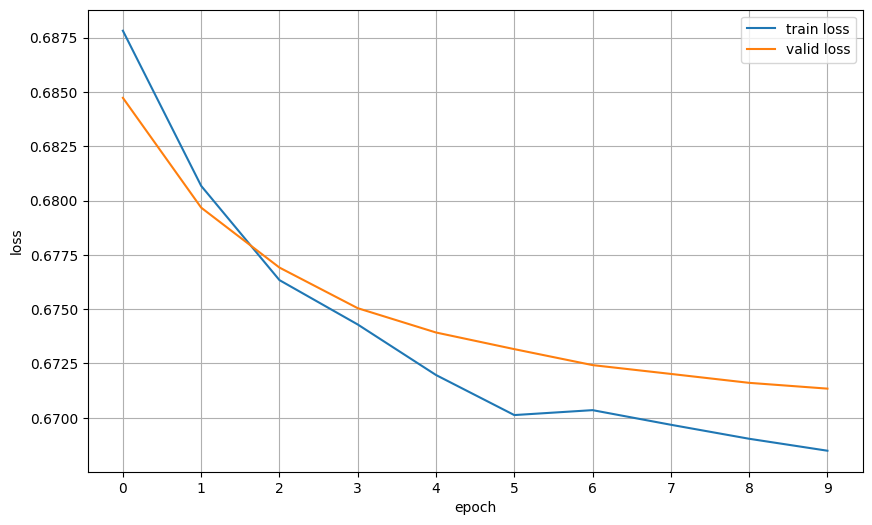

In [32]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

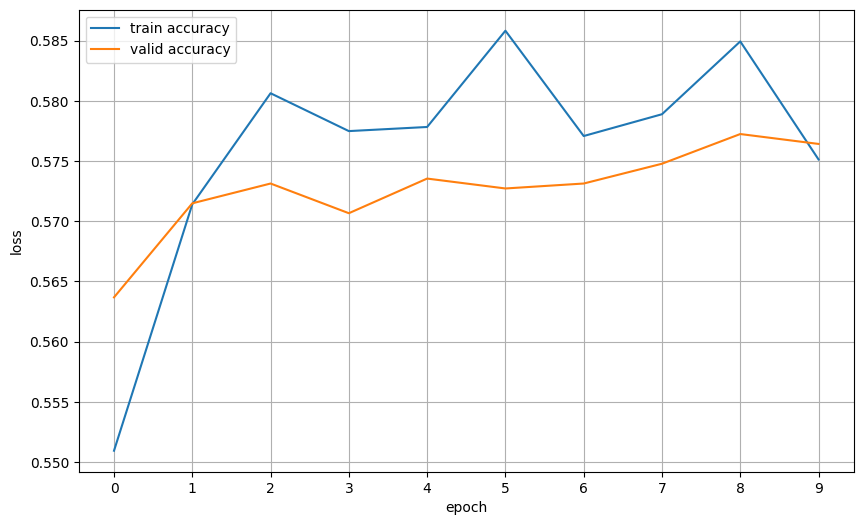

In [33]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [34]:
model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 271/271 [00:26<00:00, 10.38it/s]


In [35]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.662, test_acc: 0.601
